
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 2<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    RL Post-training <br>

Student Numebr =

Name = 

# Post training an LLM for reasoning with GRPO in TRL after SFT

In this notebook, we'll guide you through the process of post-training a Large Language Model (LLM) using **Group Relative Policy Optimization (GRPO)**, a method introduced in the [DeepSeekMath paper](https://arxiv.org/abs/2402.03300). GRPO is particularly effective for **scaling test-time compute for extended reasoning**, making it an ideal approach for solving complex tasks, such as mathematical problem-solving.

GRPO is a **reinforcement learning (RL) post-training technique** that was integrated into the training pipeline for **DeepSeek-R1**. It seems to share similarities with the training procedures used in the latest [**OpenAI o1 and o3 models**](https://openai.com/index/learning-to-reason-with-llms/), though the exact alignment is not confirmed. Unlike earlier techniques that relied on search-heuristic methods, GRPO exclusively employs **RL** for post-training, enhancing the model's capacity to handle complex and nuanced tasks.

In this notebook, we'll follow a two-stage pipeline:

1. **Supervised Fine‑Tuning (SFT)**: Next, we’ll perform traditional SFT on the same data to teach the model via ground‑truth solutions.  
2. **GRPO after SFT**: Finally, we’ll apply a second round of GRPO to the SFT‑enhanced model, combining reinforcement and supervised learning for maximal reasoning power.

### Supervised Fine‑Tuning (SFT)

SFT uses problem–solution pairs to directly teach the model correct reasoning via maximum‑likelihood training. This anchors the model to ground‑truth outputs before any RL step.

### Why SFT before the final GRPO?

After the first GRPO pass, the model may drift from precise solutions. A quick SFT stage:

- **Stabilizes** output distributions  
- **Boosts** the effectiveness of the subsequent GRPO  



## 1- Supervised Fine‑Tuning (SFT)(20 point)

SFT directly optimizes the model via maximum‑likelihood training on ground‑truth problem–solution pairs, whereas GRPO relies on reinforcement signals without labeled targets. It provides a strong foundation before applying RL and can boost subsequent GRPO improvements.



### 1.1 Install Dependencies

Let’s start by installing the essential libraries we’ll need for fine-tuning! 🚀


In [1]:
!pip install  -U -q trl peft math_verify
# Tested with transformers==4.47.1, trl==0.14.0, datasets==3.2.0, peft==0.14.0, accelerate==1.2.1, math_verify==0.3.3

Authenticate with your Hugging Face account.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 1.2 Load Dataset 📁

These models excel at tasks that require **complex reasoning**. A prime example is **mathematical problem-solving**, which often demands multi-step reasoning to arrive at a correct solution.

For this project, we'll use the ```AI-MO/NuminaMath-TIR``` dataset. This is a **reasoning-focused dataset** that contains mathematical problems, their solutions, and detailed reasoning steps that explain how to transition from the problem statement to the final solution.


In [3]:
from datasets import load_dataset
dataset_id = 'AI-MO/NuminaMath-TIR'
train_ds, test_ds = load_dataset(dataset_id, split=['train[:5%]', 'test[:5%]'])

Let's check the structure of the dataset.

In [4]:
print(train_ds)

Dataset({
    features: ['problem', 'solution', 'messages'],
    num_rows: 3622
})


Let's check one sample:

In [5]:
print(train_ds[0])

{'problem': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.', 'solution': "To determine the coefficient of \\(x^2y^6\\) in the expansion of \\(\\left(\\frac{3}{5}x - \\frac{y}{2}\\right)^8\\), we can use the binomial theorem.\n\nThe binomial theorem states:\n\\[\n(a + b)^n = \\sum_{k=0}^{n} \\binom{n}{k} a^{n-k} b^k\n\\]\n\nIn this case, \\(a = \\frac{3}{5}x\\), \\(b = -\\frac{y}{2}\\), and \\(n = 8\\).\n\nWe are interested in the term that contains \\(x^2y^6\\). In the general term of the binomial expansion:\n\\[\n\\binom{8}{k} \\left(\\frac{3}{5}x\\right)^{8-k} \\left(-\\frac{y}{2}\\right)^k\n\\]\n\nTo get \\(x^2\\), we need \\(8 - k = 2\\), thus \\(k = 6\\).\n\nSubstituting \\(k = 6\\) into the expression:\n\\[\n\\binom{8}{6} \\left(\\frac{3}{5}x\\right)^{8-6} \\left(-\\frac{y}{2}\\right)^6 = \\binom{8}{6} \\left(\\frac{3}{5}x\\right)^2 \\left(-\\frac{y}{2}\\right)^6\n\\]\n\nNow, we wi

### 1.3 Wrapping Solutions in `<think>` and `<answer>` Tags

This cell defines and applies a helper function, `wrap_think_answer`, which converts each example’s LaTeX‐style solution into our conversational format:

1. **Locate the answer**  
   - Searches for the `\boxed{…}` marker in the solution string  
   - Raises an error if no `\boxed{…}` or if braces are unbalanced  

2. **Extract reasoning vs. final answer**  
   - **Reasoning** (`<think>…</think>`) ← everything *before* `\boxed{`  
   - **Answer** (`<answer>…</answer>`) ← the contents *inside* the braces  

3. **Rewrite the example**  
   - Replaces the original `solution` field with the wrapped format  

Finally, it maps this transformation over both `train_ds` and `test_ds`, so all datasets use the new `<think>…</think><answer>…</answer>` convention.  


In [6]:
import re

def wrap_think_answer(ex):
    ## TODO
    
    return ex

train_ds = train_ds.map(wrap_think_answer)
test_ds  = test_ds.map(wrap_think_answer)


In the **DeepSeek-R1** training procedure, a specific system prompt was used to generate a conversational pipeline that includes reasoning steps. We'll adapt our dataset to follow this approach, where the model is guided to first think through the problem and then present its answer.

The system prompt used is:

```
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>. User: prompt. Assistant:
```

We will modify our dataset to follow this conversational format, prompting the LLM to generate both the reasoning steps and the final answer.








In [7]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, "
    "and the Assistant solves it. The assistant first thinks about the reasoning "
    "process in the mind and then provides the user with the answer. "
    "The reasoning process and answer are enclosed within <think> </think> and "
    "<answer> </answer> tags."
)

def make_conversation(ex):
    return {
        "prompt": [
            ## TODO create roles and their corresponding messages
        ],
        "solution": ex.get("solution", "")
    }

train_ds = train_ds.map(make_conversation)
test_ds  = test_ds.map(make_conversation)

Let's take a look at an example:

In [8]:
print(train_ds[0]['prompt'])

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags.', 'role': 'system'}, {'content': 'What is the coefficient of $x^2y^6$ in the expansion of $\\left(\\frac{3}{5}x-\\frac{y}{2}\\right)^8$?  Express your answer as a common fraction.', 'role': 'user'}]


We'll remove the `messages` and `problem` columns, as we only need the custom `prompt` column and `solution` to verify the generated answer.  

In [10]:
## TODO
print(train_ds)

Dataset({
    features: ['solution', 'prompt'],
    num_rows: 3622
})


### 1.4 Loading the Baseline Model

To begin, we'll load [Qwen/Qwen2-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2-0.5B-Instruct) as the baseline model (`Policy Model` in the diagram above). With only 0.5 billion parameters, it is lightweight and fits within the available resources.

In [ ]:
model_id = "Qwen/Qwen2-0.5B-Instruct"
model = ## TODO

In [12]:
# Optional memory-saving tweaks:
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

### 1.5 Tokenization and Dataset Formatting

This step transforms our raw conversational examples into the fixed‑length, numerical format the model requires:

- **Instantiate the tokenizer** for our chosen pretrained model.
- **Define a mapping function** that:
  1. Merges each example’s prompt and solution into one continuous text.
  2. Converts that text into token IDs, applies truncation and padding.
  3. Generates the corresponding attention mask and training labels.
- **Apply the function** across the entire training and evaluation datasets, replacing the original text fields with `input_ids`, `attention_mask`, and `labels`.

The result is two ready‑to‑use datasets of equal length sequences, primed for causal language model fine‑tuning.  


In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=False)

def tokenize_fn(examples):
    batch_input_ids, batch_attention_mask, batch_labels = [], [], []
    for prompt, sol in zip(examples["prompt"], examples["solution"]):
        p = ## TODO
        full = ## TODO
        tok = tokenizer(full, truncation=True, padding="max_length", max_length=200)
        ids = tok["input_ids"]
        batch_input_ids.append(ids)
        batch_attention_mask.append(tok["attention_mask"])
        # teach model to reproduce full sequence
        batch_labels.append(ids.copy())
    return {
        "input_ids": batch_input_ids,
        "attention_mask": batch_attention_mask,
        "labels": batch_labels
    }

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=["prompt","solution"])
test_ds  = test_ds.map(tokenize_fn, batched=True, remove_columns=["prompt","solution"])


### 1.6 Data collator

- **Data collator**: `DataCollatorForLanguageModeling(tokenizer, mlm=False)` batches and pads inputs for causal LM.  
```python


In [14]:
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Data collator for causal LM
## TODO

## 1.7  Configuring sft Training Parameters

In [15]:
sft_args = TrainingArguments(
    output_dir="Qwen2-0.5B-SFT-full",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    learning_rate=5e-5,
    bf16=True,
    logging_steps=50,
    report_to=["tensorboard"],
    push_to_hub=True,
    save_strategy="steps",
    save_steps=4500,
    remove_unused_columns=False,
)

## 1.8 Training the Model 🏃

Now, let's configure the trainer and start training the model!

In [16]:
trainer = Trainer(
    model=model,
    args=sft_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipykernel_957704/1373408976.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Time to train the model! 🎉

In [ ]:
trainer.train()


## 2- Post training an LLM for reasoning with GRPO in TRL after SFT (30 point)


Below is a diagram illustrating how this training procedure works.









![Image](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/grpo_visual.png)

## 2.1 Load Dataset 📁


In [18]:
from datasets import load_dataset

dataset_id = 'AI-MO/NuminaMath-TIR'
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:5%]', 'test[:5%]'])

In the **DeepSeek-R1** training procedure, a specific system prompt was used to generate a conversational pipeline that includes reasoning steps. We'll adapt our dataset to follow this approach, where the model is guided to first think through the problem and then present its answer.

The system prompt used is:

```
A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks about the reasoning process in the mind and then provides the user
with the answer. The reasoning process and answer are enclosed within <think> </think> and
<answer> </answer> tags, respectively, i.e., <think> reasoning process here </think>
<answer> answer here </answer>. User: prompt. Assistant:
```

We will modify our dataset to follow this conversational format, prompting the LLM to generate both the reasoning steps and the final answer.








In [20]:
SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)

def make_conversation(example):
    return {
        "prompt": [
            ## TODO create roles and their corresponding messages
        ],
    }

train_dataset = train_dataset.map(make_conversation)
test_dataset = test_dataset.map(make_conversation)

Let's take a look at an example:

We'll remove the `messages` and `problem` columns, as we only need the custom `prompt` column and `solution` to verify the generated answer.  

In [22]:
## TODO
print(train_dataset)

Dataset({
    features: ['solution', 'prompt'],
    num_rows: 3622
})


##  Post-Training the Model Using GRPO

The diagram below highlights the main differences between **PPO** (Proximal Policy Optimization) and **GRPO** (Group Relative Policy Optimization), specifically the removal of the value model in GRPO.

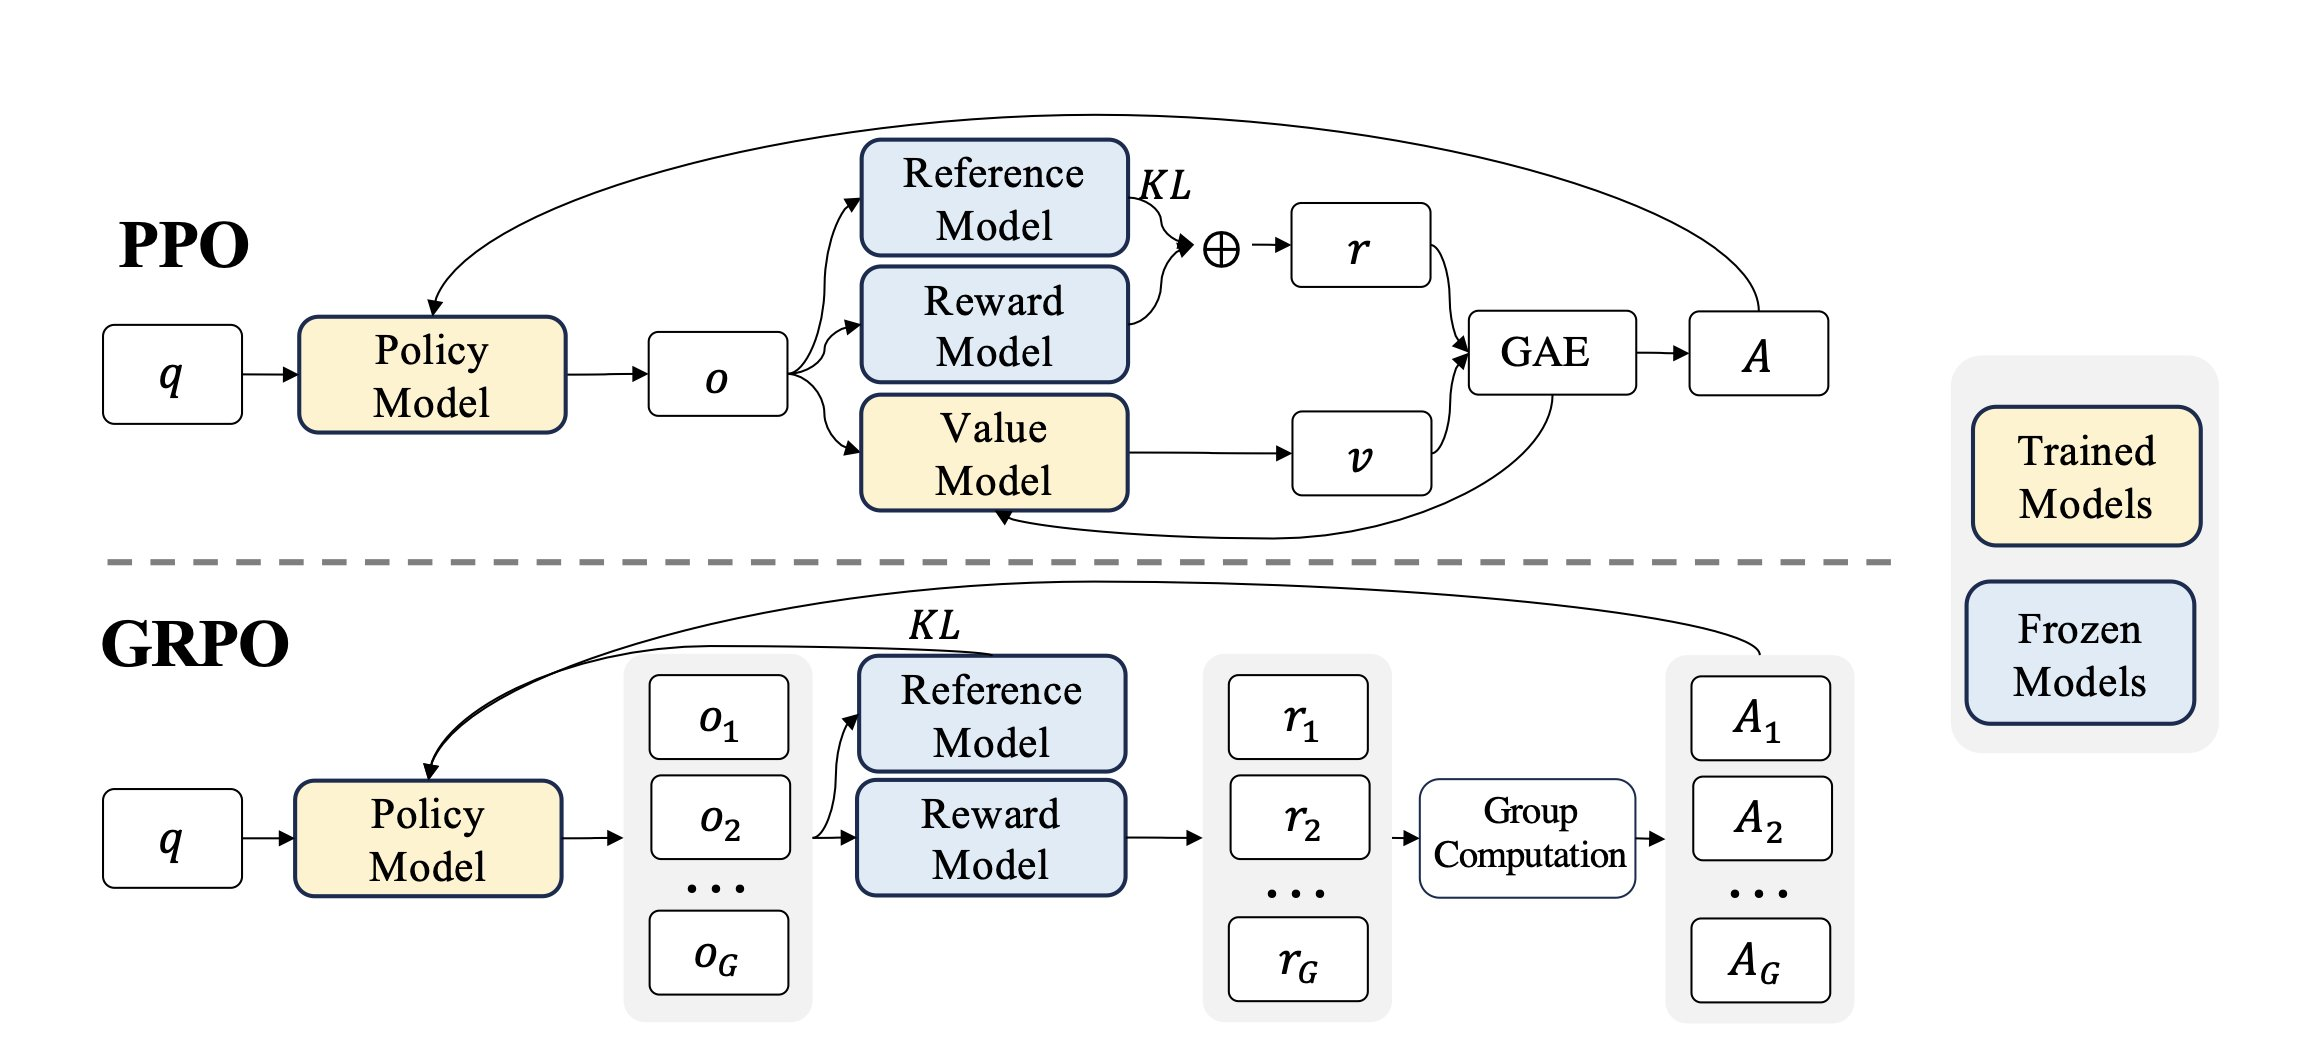

### 2.2 Loading the SFT‑Fine‑Tuned Baseline Model

First, we load the SFT‑trained Qwen2-0.5B-SFT-full as our policy model. With just 0.5 billion parameters.

In [25]:
model_id = "Qwen2-0.5B-SFT-full" # where you save the sft model
model = ## TODO

### 2.3 Configuring LoRA

Next, we will configure LoRA for model training. This technique will allow us to efficiently fine-tune the model with a reduced number of parameters, enabling faster and more resource-efficient training.

In [26]:
from peft import LoraConfig, get_peft_model

lora_config = ## TODO

model = ## TODO

model.print_trainable_parameters()

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


### 2.4 Loading Reward Functions

For the reward component of the system, we can use either pretrained reward models or reward functions defined directly in code. For training, the DeepSeek-R1 authors used an accuracy-based reward model evaluates whether the response is correct, alongside a format-based reward that ensures the model places its reasoning process between `<think> </think>` tags.

In this case, we will utilize these reward functions:

1. **Format Enforcement:** Ensures that the generation follows a specific format using `<think> </think> <answer> </answer>` tags for reasoning.  

In [27]:
import re
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    """Get a list of generated answers and return a list containing 1 if they follow the specific format and 0 o.w."""
    rewards_list = [
        ## TODO        
    ]
    return rewards_list

2. **Solution Accuracy:** Verifies whether the solution to the problem is correct.

In [28]:
from math_verify import LatexExtractionConfig, parse, verify
def accuracy_reward(completions, **kwargs):
    """Reward function that checks if the completion is the same as the ground truth. 1 if the answer is correct and 0 o.w."""
    solutions = kwargs['solution']
    completion_contents = [completion[0]["content"] for completion in completions]
    rewards = []
    for content, solution in zip(completion_contents, solutions):
        ## TODO 
    return rewards

### 2.5 Configuring GRPO Training Parameters

Next, let's configure the training parameters for GRPO. We recommend experimenting with the `max_completion_length`, `num_generations`, and `max_prompt_length` parameters.

To keep things simple, we’ll start by training for just one epoch and reducing the `max_completion_length`, `num_generations`, and `max_prompt_length` from their default values.

In [29]:
from trl import GRPOConfig

# Configure training arguments using GRPOConfig
training_args = GRPOConfig(
    output_dir="Qwen2-0.5B-GRPO-test",
    learning_rate=1e-5,
    remove_unused_columns=False, # to access the solution column in accuracy_reward
    gradient_accumulation_steps=16,
    num_train_epochs=1,
    bf16=True,

    # Parameters that control de data preprocessing
    max_completion_length=64, # default: 256
    num_generations=4, # default: 8
    max_prompt_length=128, # default: 512

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
)

### 2.6 Training the Model 🏃

Now, let's configure the trainer and start training the model!

In this case, we pass the two reward functions we previously defined to the trainer

Below, you'll find a diagram of the training procedure we'll be reproducing, which is sourced from the Open-R1 project.

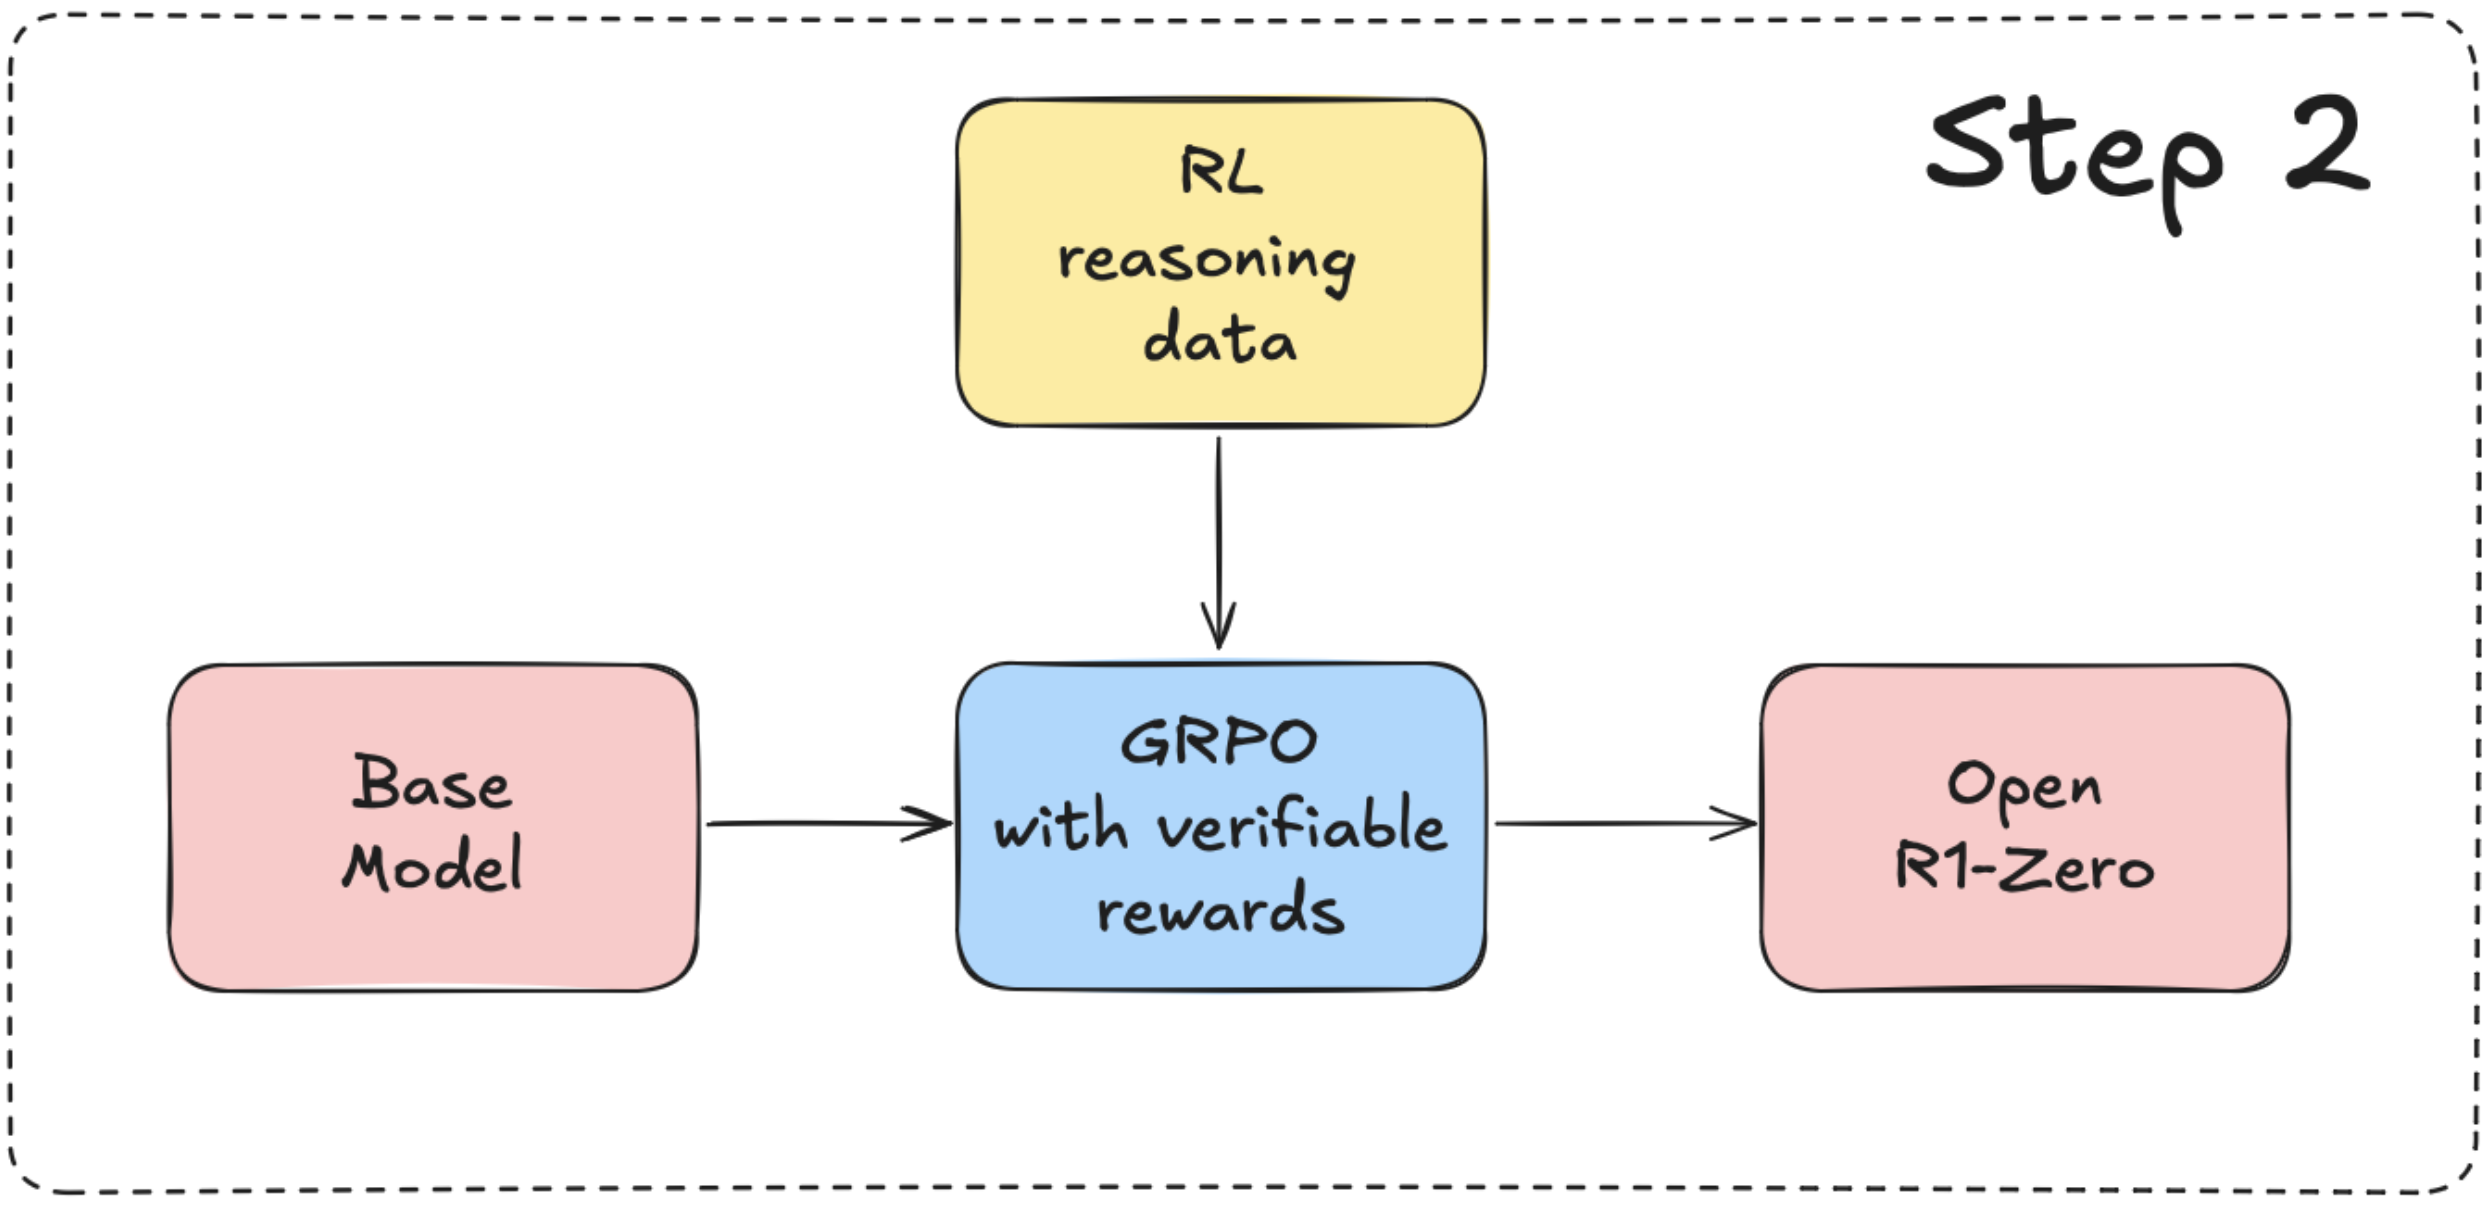

In [30]:
from trl import GRPOTrainer

trainer = ## TODO 

INFO 04-19 22:31:00 [__init__.py:239] Automatically detected platform cuda.


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Time to train the model! 🎉

In [ ]:
trainer.train()

Let's save the results 💾

In [ ]:
trainer.save_model(training_args.output_dir)
trainer.push_to_hub(dataset_name=dataset_id)

Below, you can review the Tensorboard results for the training. They look promising!

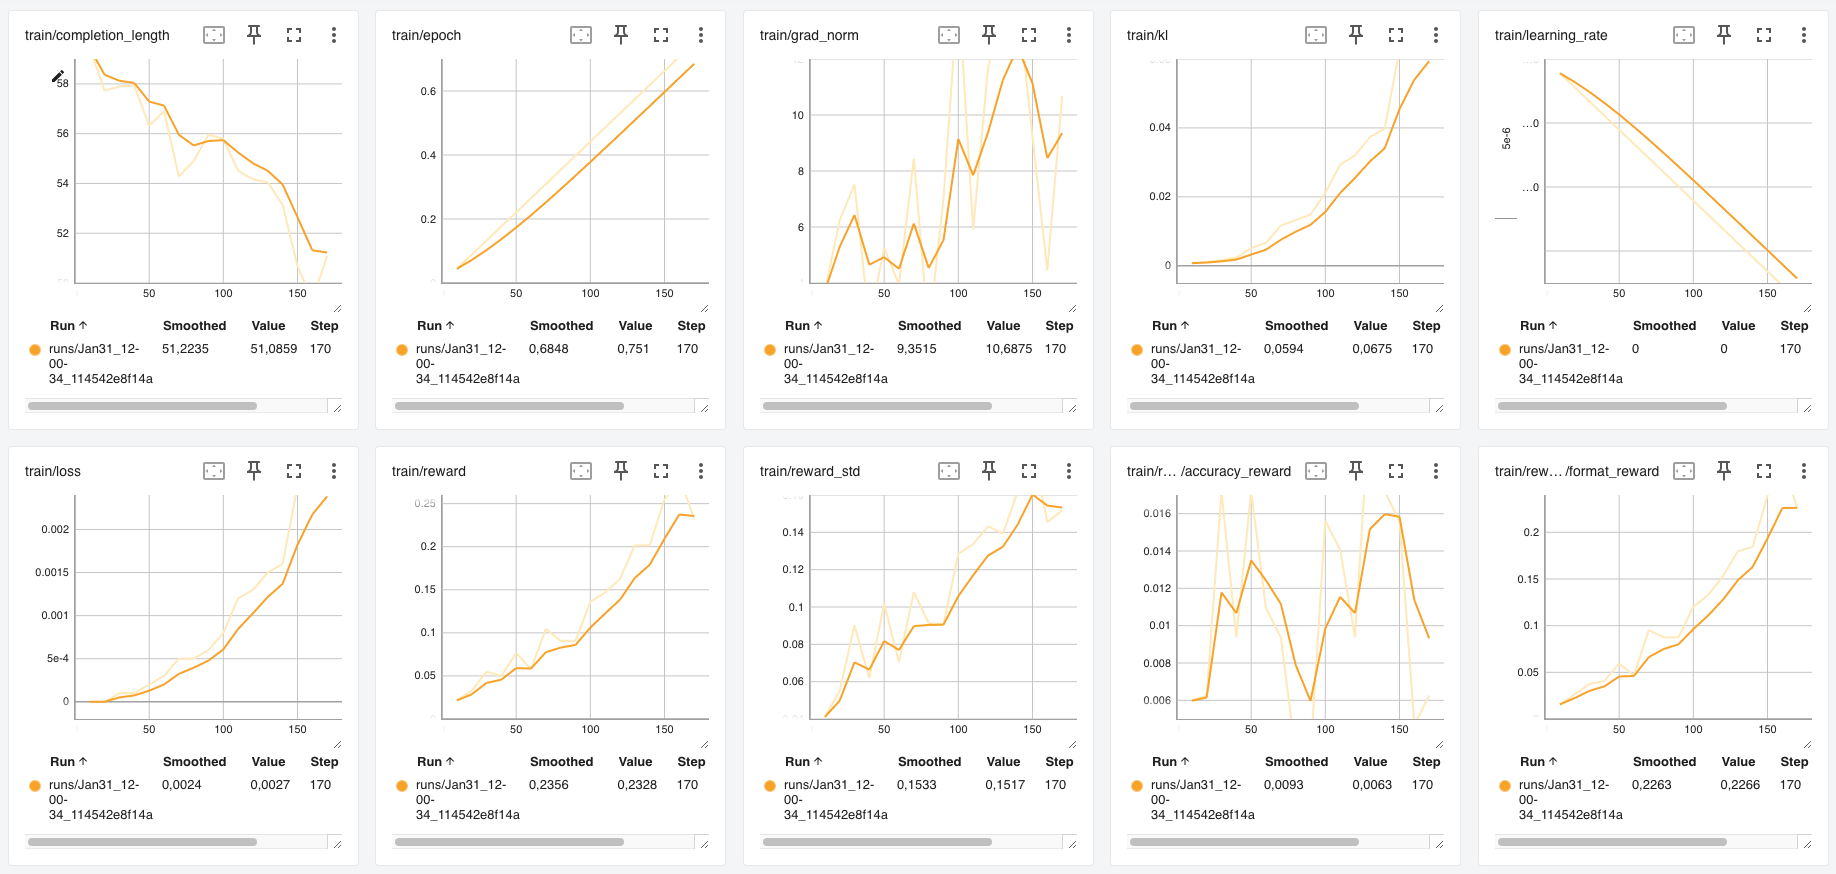

 ### 2.7 GRPO from scratch

 Now let's implement the grpo objective from scratch and train another model.

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam

class GRPOTrainer:
    def __init__(self, model, reward_funcs, train_dataset, lr=1e-5, batch_size=8, num_epochs=1):
        self.model = model
        self.reward_funcs = reward_funcs
        self.train_dataset = train_dataset
        self.lr = lr
        self.batch_size = batch_size
        self.num_epochs = num_epochs

        self.optimizer = Adam(model.parameters(), lr=self.lr)

    def compute_rewards(self, batch):
        """Compute the rewards using the defined reward functions."""
        ## TODO 
        return rewards

    def compute_group_relative_rewards(self, rewards):
        """
        Compute the group-relative rewards for the actions.
        This involves normalizing the rewards based on the group (batch) to create relative rewards.
        """
        ## TODO 
        return relative_rewards

    def update_model(self, relative_rewards):
        """Update the model using GRPO update with group-relative rewards."""
        loss = ## TODO

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self):
        """Train the model using GRPO."""
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            for batch in self.train_dataset:

                rewards = self.compute_rewards(batch)


                relative_rewards = self.compute_group_relative_rewards(rewards)


                loss = self.update_model(relative_rewards)
                epoch_loss += loss
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {epoch_loss}")
        return self.model

trainer = ## TODO 

trained_model = ## TODO 
## TODO Save the trained model

## 3- Check the Model Performance (50 point)

We've kept things simple so far, but now let's check if the model has already learned to reason. We'll load the saved model and run an evaluation on a test sample.

### TRL Library

In [ ]:
from transformers import AutoTokenizer

model_id = "sergiopaniego/Qwen2-0.5B-GRPO"
trained_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(model_id)

### From Scratch

In [ ]:
model_id = "sergiopaniego/Qwen2-0.5B-GRPO"
trained_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
)
trained_tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's check one sample from the test set!

In [ ]:
print(test_dataset['prompt'][0])

[{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>', 'role': 'system'}, {'content': "In 1988, a person's age was equal to the sum of the digits of their birth year. How old was this person?", 'role': 'user'}]


We'll create a function to interact with the model. In addition to generating the answer, we'll measure the inference duration and count the number of generated tokens. This will give us insights into how much the model has reasoned during generation.

In [ ]:
import time

def generate_with_reasoning(prompt):
  # Build the prompt from the dataset
  prompt = " ".join(entry['content'] for entry in prompt)

  # Tokenize and move to the same device as the model
  inputs = ## TODO 

  # Generate text without gradients
  start_time = time.time()
  with torch.no_grad():
      output_ids = ## TODO 
  end_time = time.time()

  # Decode and extract model response
  generated_text = ## TODO 

  # Get inference time
  inference_duration = end_time - start_time

  # Get number of generated tokens
  num_input_tokens = ## TODO 
  num_generated_tokens = ## TODO 

  return generated_text, inference_duration, num_generated_tokens

Let's generate the answer for that test sample!

In [ ]:
prompt = test_dataset['prompt'][0]
generated_text, inference_duration, num_generated_tokens = generate_with_reasoning(prompt)
print(generated_text)

A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer> In 1988, a person's age was equal to the sum of the digits of their birth year. How old was this person?<think>
The reasoning process is that if the sum of the digits of the birth year is equal to the person's age, then the person must have been born in a given year.

<think>
The answer is: 1988
</think>


The model already demonstrates the ability to generate the correct `<think>` and `<answer>` tags, even though the solution itself is incorrect.

Given the inference time and the number of generated tokens, this approach shows potential benefits:

In [ ]:
print(f"Inference time: {inference_duration:.2f} seconds")
print(f"Generated tokens: {num_generated_tokens}")

Inference time: 2.09 seconds
Generated tokens: 55


Let’s review the generated response to better visualize this behavior:

In [ ]:
prompt_text = " ".join(entry['content'] for entry in prompt)
response_text = generated_text[len(prompt_text):].strip()
print(response_text)

<think>
The reasoning process is that if the sum of the digits of the birth year is equal to the person's age, then the person must have been born in a given year.

<think>
The answer is: 1988
</think>


We observe that the model demonstrates some reasoning capabilities, although these are limited. This can be attributed to several factors: the use of a small model, a limited subset of the dataset, and a short training duration to keep the process simple and practical for a notebook environment.

Despite these constraints, this technique shows great promise. The release of DeepSeek-R1 and the adoption of this training approach could lead to significant breakthroughs in the coming months!